In [197]:
import pandas as pd
from IPython.display import HTML, display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from __future__ import annotations
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [217]:
# in the following, you can find all the code used to create insights for the following kaggle challenge:
# https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [3]:
data = pd.read_csv('./AIA_Churn_Modelling_Case_Study.csv')

In [4]:
def display_df_with_all_columns(x: pd.DataFrame):
    pd.set_option("display.max_columns", None)
    display(x)
    pd.reset_option("display.max_columns")

In [5]:
display_df_with_all_columns(data)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


# Data Cleaning/Exploration and Preprocessing

In [6]:
# first I checked the columns and their dtypes
column_to_dtype = {col: str(data[col].dtype) for col in data.columns }

In [7]:
column_to_dtype

{'customerID': 'object',
 'gender': 'object',
 'SeniorCitizen': 'int64',
 'Partner': 'object',
 'Dependents': 'object',
 'tenure': 'int64',
 'PhoneService': 'object',
 'MultipleLines': 'object',
 'InternetService': 'object',
 'OnlineSecurity': 'object',
 'OnlineBackup': 'object',
 'DeviceProtection': 'object',
 'TechSupport': 'object',
 'StreamingTV': 'object',
 'StreamingMovies': 'object',
 'Contract': 'object',
 'PaperlessBilling': 'object',
 'PaymentMethod': 'object',
 'MonthlyCharges': 'float64',
 'TotalCharges': 'object',
 'Churn': 'object'}

In [8]:
clean_data = data.copy()

In [9]:
# 1. handle the dtype of "TotalCharges", it is not of type of float. It also comprises empty values (for newly acquired customers this month)
# 2. SeniorCitizen is binary, but not consistent with the rest of the categorical columns (Yes/No values). Change that
# 3. Remove the customerID, we will work with the row numbers as index
# 4. Rename columns to have consistent naming

rows_with_missing_total_charges = clean_data[clean_data['TotalCharges'] == ' '].index
clean_data.loc[rows_with_missing_total_charges, 'TotalCharges'] = clean_data.loc[rows_with_missing_total_charges]['MonthlyCharges']
clean_data['TotalCharges'] = clean_data['TotalCharges'].astype(float)

clean_data['SeniorCitizen'] = ['Yes' if value else 'No' for value in clean_data['SeniorCitizen']]
clean_data = clean_data.drop(columns=['customerID'])
clean_data = clean_data.rename(columns={'gender': 'Gender', 'tenure': 'Tenure'})



In [10]:
# now I want to get a better feeling about the churn-rates 

In [11]:
def create_pie_charts_for_churn_rate_and_revenue_loss(data: pd.DataFrame):
    explode = (0, 0.15, 0.15)
    colors = ['white', '#8b0000', '#000048']
    start_angle = 180
    bbox_anchor = (0.65, 0.9)
    
    churned_customers = data[data['Churn'] == 'Yes']
    new_customers_acquired = data[(data['tenure'] == 0) & (data['Churn'] == 'No')]
    
    n_customers_lost = len(churned_customers)
    n_new_customers = len(new_customers_acquired)
    n_remaining_customers = len(data) + n_new_customers - n_customers_lost
    
    plt.pie([n_remaining_customers, n_customers_lost, n_new_customers], explode=explode, colors=colors, startangle=start_angle)

    plt.gca().patches[0].set_edgecolor('black')
    
    plt.legend(labels=['Remaining Customers', 'Lost Customers', 'Newly Acquired Customers'], loc="upper left", bbox_to_anchor=bbox_anchor)
    
    print(f"Churn Rate: {(n_customers_lost / len(data) * 100):.2f} (rel), {n_customers_lost} (abs), new customers: {n_new_customers}, Net customer loss: { 100 - (n_remaining_customers / len(data)) * 100:.2f}")
    plt.show()
    
    
    
    total_amount_of_revenue = data['MonthlyCharges'].sum()
    lost_revenue = churned_customers['MonthlyCharges'].sum()
    new_revenue = new_customers_acquired['MonthlyCharges'].sum()
    remaining_revenue = total_amount_of_revenue -  lost_revenue + new_revenue
    
    plt.pie([remaining_revenue, lost_revenue, new_revenue], explode=explode, colors=colors, startangle=start_angle)

    plt.gca().patches[0].set_edgecolor('black')
    
    plt.legend(labels=['Remaining Revenue', 'Lost Revenue', 'Additional Revenue'], loc="upper left",  bbox_to_anchor=bbox_anchor)
    
    print(f"Revenue Lost: {(lost_revenue / total_amount_of_revenue * 100):.2f} (rel), {lost_revenue:.2f} (abs), new revenue: {new_revenue}, , Net revenue loss: { 100 - (remaining_revenue / total_amount_of_revenue) * 100:.2f}")
    plt.show()

Churn Rate: 26.54 (rel), 1869 (abs), new customers: 11, Net customer loss: 26.38


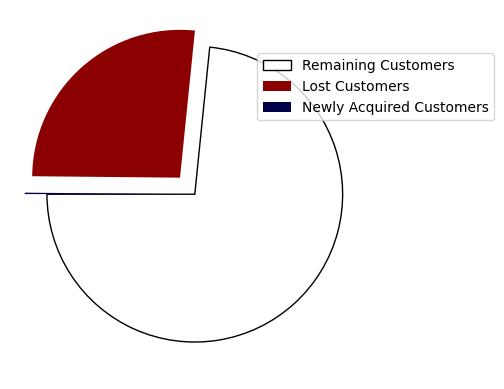

Revenue Lost: 30.50 (rel), 139130.85 (abs), new revenue: 455.5999999999999, , Net revenue loss: 30.40


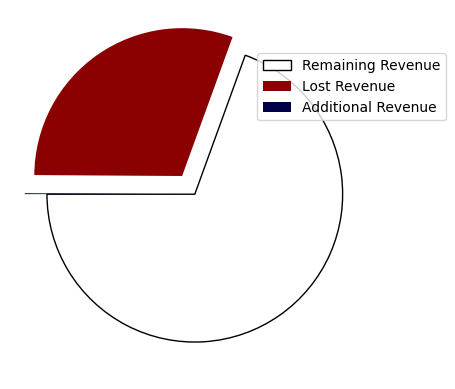

In [12]:
create_pie_charts_for_churn_rate_and_revenue_loss(data)

In [219]:
# check for causes of the high-churn rate
# but first, let's merge some of the data columns that seem to have similar values and are not really relevant

In [71]:
data_with_enriched_features = clean_data.copy()

data_with_enriched_features['Streaming'] = ['Yes' if value else 'No' for value in ((data_with_enriched_features['StreamingTV'] == 'Yes') | (data_with_enriched_features['StreamingMovies'] == 'Yes')).to_list()]
data_with_enriched_features.drop(columns=['StreamingTV', 'StreamingMovies'], inplace=True)

In [15]:
data_with_enriched_features = clean_data.copy()

data_with_enriched_features['Streaming'] = ['Yes' if value else 'No' for value in ((data_with_enriched_features['StreamingTV'] == 'Yes') | (data_with_enriched_features['StreamingMovies'] == 'Yes')).to_list()]
data_with_enriched_features.drop(columns=['StreamingTV', 'StreamingMovies'], inplace=True)

In [149]:
# the same applies to columns with values 'No internet service'. All columns have this value for InternetService == 'No'
# we will just replace this value completely with 'No', because no internet service also mean no e.g. 'DeviceProtection'. Reduces the feature space
def replace_no_internet_service_value(data: pd.DataFrame) -> pd.DataFrame:
    for column in data.columns:
        if data[column].dtype == 'object' and 'No internet service' in data[column].unique():
            data[column].replace(['No internet service'], 'No', inplace=True)
        
    return data

data_with_enriched_features = replace_no_internet_service_value(data_with_enriched_features)

In [150]:
# let's create a representation for the feature importance using "bubble plots"
# I utilize a logistic regression as a first approach of getting a glimpse on the feature importances. The dataset is unbalanced so we utilize class-weights and a L2
# regularization to counteract this

In [215]:
from sklearn.linear_model import LogisticRegression


def flatten_nested_list(lst: list[list]) -> list:
    return [item for sublist in lst for item in sublist]


def remove_elements_from_list_by_indices(original_list: list, indices: list[int]) -> list:
    indices_set = set(indices)
    return [item for idx, item in enumerate(original_list) if idx not in indices_set]


def merge_values_if_possible(features: list[str], correlations: list[float], amount_of_values: list[int]) -> tuple[list[str], list[float], list[int]]:
    """ 
        This method merges a list of features into one (together with their correlations and affected user amount)
        to get a better visualization in the bubble plot later
    """
    corr_value_tuples = list(zip(correlations, amount_of_values))
        
    all_indices_to_merge: list[list] = []
    indices_already_considered = set()
    for i, (corr, value_amout) in enumerate(corr_value_tuples):
        indices = {i}
        for j in range(i + 1, len(corr_value_tuples)):
            comp_corr, comp_value_amount = corr_value_tuples[j]
            
            if abs(comp_corr - corr) <= 0.02 and abs(comp_value_amount - value_amout) <= 200 and j not in indices_already_considered:
                indices.add(j)
        
        if len(indices) > 1:
            all_indices_to_merge.append(list(indices))
            
        indices_already_considered.update(indices)
    
    
    new_features = []
    new_correlations = []
    new_amounts = []
    for indices_of_features_to_merge in all_indices_to_merge:
        indices_of_features_to_merge = list(indices_of_features_to_merge)
        
        new_feature = "_".join(np.array(features)[indices_of_features_to_merge])
        new_correlation = np.mean(np.array(correlations)[indices_of_features_to_merge])
        new_amount = int(np.mean(np.array(amount_of_values)[indices_of_features_to_merge]))
        
        new_features.append(new_feature)
        new_correlations.append(new_correlation)
        new_amounts.append(new_amount)
        
    
    indices_to_remove =  flatten_nested_list(all_indices_to_merge)
    
    lists_to_return = []
    for list_to_adapt, list_to_add in zip([features, correlations, amount_of_values], [new_features, new_correlations, new_amounts]):
        list_to_adapt = remove_elements_from_list_by_indices(list_to_adapt, indices_to_remove)
        list_to_adapt.extend(list_to_add)
        lists_to_return.append(list_to_adapt)
        
    return tuple(lists_to_return)


def create_bubble_correlation_chart(
        correlation_series: pd.Series, 
        one_hot_encoded_data: pd.DataFrame,
        y_lim: tuple,
        x_lim: tuple,
        bubble_size: int = 8
    ):
    
    lower_y_limit = y_lim[0]
    upper_y_limit = y_lim[1]
    
    features = correlation_series.index.to_list()
    correlations = correlation_series.to_list()
    
    amount_of_values = [sum(one_hot_encoded_data[feature] == 1) 
                        if one_hot_encoded_data[feature].dtype == 'uint8' else len(one_hot_encoded_data) for feature in features]
    

    features, correlations, amount_of_values = merge_values_if_possible(features, correlations, amount_of_values)

    bubble_sizes = len(amount_of_values) * bubble_size
    
    plt.figure(figsize=(14, 8))
    
    plt.scatter(correlations, amount_of_values, 
                s=bubble_sizes, alpha=0.6)
        
    for i, feature in enumerate(features):
        if amount_of_values[i] < lower_y_limit:
            continue
        
        
        adapted_feature_name = feature
        splittable = len(adapted_feature_name.split('_')) > 1
        
        if splittable:
            adapted_feature_name = adapted_feature_name.replace('_', '\n')

        # Calculate the position for the text
        x_pos = correlations[i]
        y_pos = amount_of_values[i]
        
        # Add the text in the middle of the bubbles
        plt.text(x_pos, y_pos, adapted_feature_name, ha='center', va='center', fontsize=10, color='white')


    plt.ylabel('Affected of Customers')
    
    plt.ylim(lower_y_limit, upper_y_limit) 
    plt.xlim(x_lim[0], x_lim[1])
    plt.xticks([x_lim[0], np.mean([x_lim[0], x_lim[1]]), x_lim[1]], ['Low Importance', 'Mediocre Importance', 'High Importance'])

    plt.show()
    
    
def get_feature_importance(data: pd.DataFrame):
    standardized_data = data.copy()
        
    for c in ['Tenure', 'MonthlyCharges', 'TotalCharges']:
        scaler = StandardScaler()
        standardized_data[c] = scaler.fit_transform(standardized_data[c].to_numpy().reshape(-1, 1))
        
    X = pd.get_dummies(standardized_data.drop('Churn', axis=1))

    
    y = [1 if  value  == 'Yes' else 0 for value in data['Churn']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = LogisticRegression(class_weight='balanced', max_iter = 1000)
    model.fit(X_train, y_train)
    
    one_hot_encoded_data = pd.get_dummies(data)
    
    important_features = flatten_nested_list(model.coef_)
    feature_importance = pd.Series(important_features, index=model.feature_names_in_)
    
    print(precision_recall_fscore_support(model.predict(X_test), y_test, average='binary'))

    
    return feature_importance
    
    
def create_bubble_chart_for_factors_with_positive_corr(data: pd.DataFrame):
    feature_importance = get_feature_importance(data)
    features_with_positive_coefficients = feature_importance[feature_importance > 0.00]
    
    print(features_with_positive_coefficients.sort_values())
    
    one_hot_encoded_data = pd.get_dummies(data)
    one_hot_encoded_data_churn_yes = one_hot_encoded_data[one_hot_encoded_data['Churn_Yes'] == 1]
    
    create_bubble_correlation_chart(
        features_with_positive_coefficients,
        one_hot_encoded_data_churn_yes,
        y_lim=(0, 2000),
        x_lim=(0.0, 1.0),
        bubble_size=2000
    )
    
def create_bubble_chart_for_factors_with_negative_corr(data: pd.DataFrame):
    feature_importance = get_feature_importance(data)
    features_with_negative_coefficients = feature_importance[feature_importance < 0.00]
    
    print(features_with_negative_coefficients.sort_values())
    features_with_negative_coefficients = features_with_negative_coefficients * -1
    
    one_hot_encoded_data = pd.get_dummies(data)
    one_hot_encoded_data_churn_no = one_hot_encoded_data[one_hot_encoded_data['Churn_No'] == 1]
    
    create_bubble_correlation_chart(
        features_with_negative_coefficients,
        one_hot_encoded_data_churn_no,
        y_lim=(0, 8000),
        x_lim=(0.0, 1.3),
        bubble_size=2000
    )

(0.8350515463917526, 0.552901023890785, 0.6652977412731007, None)
Contract_One year                 0.005497
Partner_Yes                       0.010868
InternetService_DSL               0.017555
Gender_Female                     0.018897
InternetService_No                0.019423
Dependents_No                     0.062290
SeniorCitizen_Yes                 0.101000
Streaming_No                      0.105418
DeviceProtection_No               0.117466
PaperlessBilling_Yes              0.153204
OnlineBackup_No                   0.180157
TechSupport_No                    0.239140
PaymentMethod_Electronic check    0.275629
OnlineSecurity_No                 0.279794
PhoneService_No                   0.344550
MultipleLines_No phone service    0.344550
TotalCharges                      0.583712
Contract_Month-to-month           0.722459
MonthlyCharges                    0.952722
dtype: float64


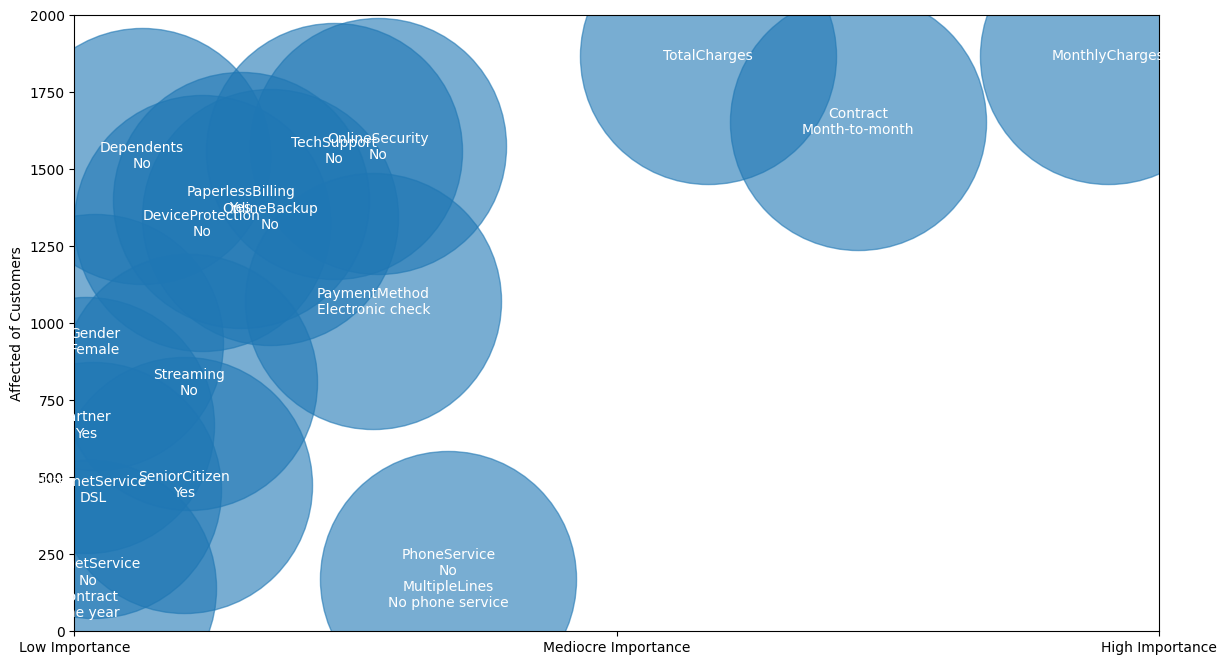

In [213]:
create_bubble_chart_for_factors_with_positive_corr(data_with_enriched_features)

(0.8350515463917526, 0.552901023890785, 0.6652977412731007, None)
Tenure                                    -1.249020
Contract_Two year                         -0.726265
PhoneService_Yes                          -0.342859
OnlineSecurity_Yes                        -0.278103
TechSupport_Yes                           -0.237450
MultipleLines_No                          -0.207459
OnlineBackup_Yes                          -0.178466
PaperlessBilling_No                       -0.151513
MultipleLines_Yes                         -0.135400
DeviceProtection_Yes                      -0.115775
PaymentMethod_Mailed check                -0.113553
Streaming_Yes                             -0.103727
SeniorCitizen_No                          -0.099310
PaymentMethod_Credit card (automatic)     -0.095718
PaymentMethod_Bank transfer (automatic)   -0.064668
Dependents_Yes                            -0.060599
InternetService_Fiber optic               -0.035288
Gender_Male                               -0.01720

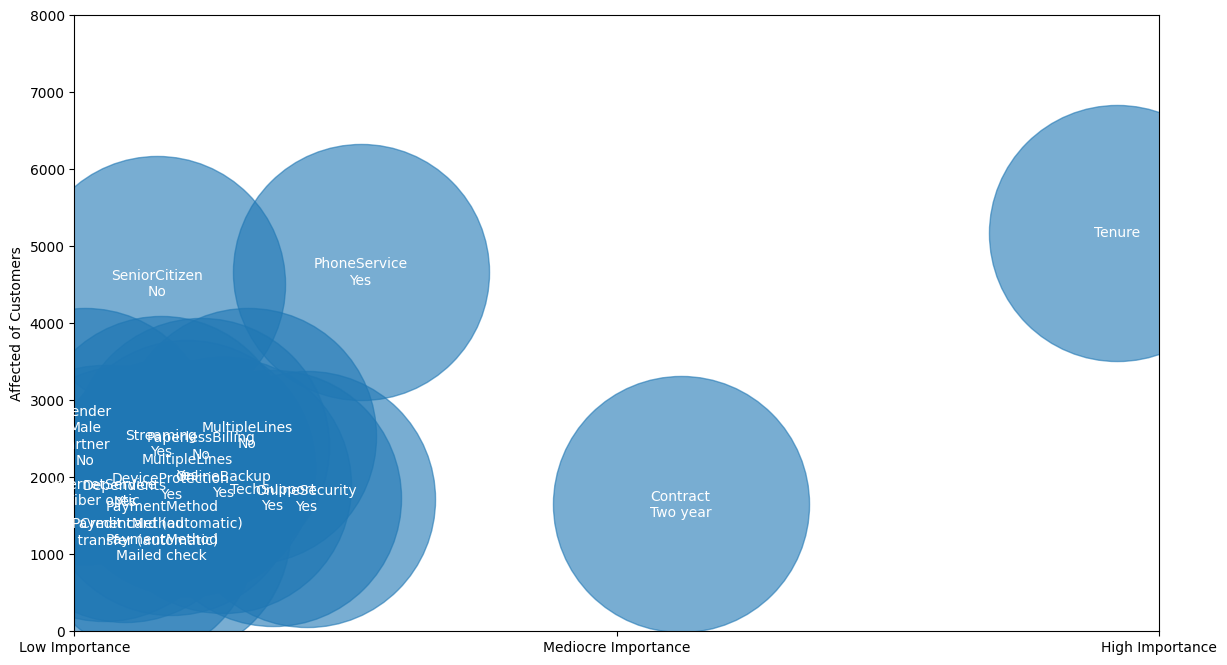

In [216]:
create_bubble_chart_for_factors_with_negative_corr(data_with_enriched_features)

In [21]:
# different things could be questioned here based on the negative and positive correlations:
# 1. the contract type (month-to-month) is one of the best predictors in terms of churn rate
# 2. Same applies to MonthlyCharges and it also affects all customers
# 3. Additional Services like TechSupport/OnlineSecurity play significant roles as part of the churn rate, if they are missing (or present) 
# the churn-rate seems to be affected

In [22]:
# due to time-constraints I focused on 2 aspects: contract type (highest correlation) and MonthlyCharges (all customers affected)

In [23]:
def create_color_custom_palette(starting_color_value: str = '#2f78c4', n_colors: int = 3) -> list[str]:
    # didn't want to deal with the details for it -> generated by ChatGPT
    
    hex_color = starting_color_value.lstrip('#')
    rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    
    def lighten_color(color, amount=0.5):
        return [color[0] + (255 - color[0]) * amount,
                color[1] + (255 - color[1]) * amount,
                color[2] + (255 - color[2]) * amount]
    
    palette = [lighten_color(rgb_color, amount=i/n_colors) for i in range(n_colors)]
    return ["#{:02x}{:02x}{:02x}".format(int(r), int(g), int(b)) for r, g, b in palette]



def create_contract_and_monthly_charges_plots(data: pd.DataFrame):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    contract_plt = sns.countplot(data, x="Churn", hue="Contract", palette=create_color_custom_palette(), ax=axs[0])
    contract_plt = contract_plt.set(xlabel='Customer Left?', ylabel='Customer Amount', title="Contract Type To Customer Amount")

    monthly_contract_data = data[data['Contract'] == 'Month-to-month']
    monhtly_charges_plt = sns.violinplot(monthly_contract_data, x="Churn", y="MonthlyCharges", palette=create_color_custom_palette())
    monhtly_charges_plt = monhtly_charges_plt.set(xlabel='Customer Left?', ylabel='Monthly Charges', title="Charges for Month-To-Month Contracts")
    
    plt.tight_layout()

    plt.subplots_adjust(wspace=0.2)

    plt.show()


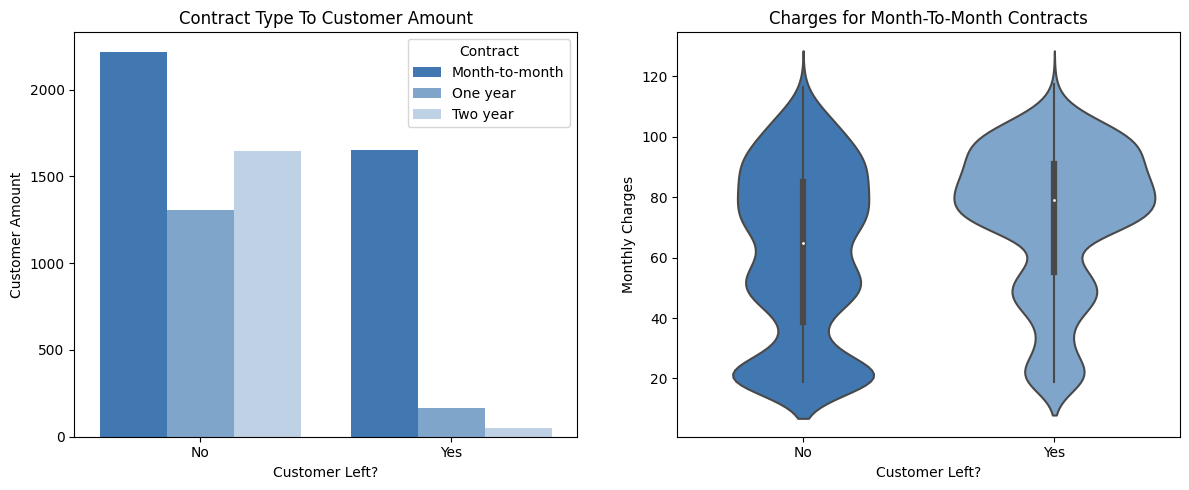

In [24]:
create_contract_and_monthly_charges_plots(data_with_enriched_features)

# Model Creation

* Two questions to answer with models
    1. Can we simulate/predict the churn of users for the next month?
    2. What are the driving features that determine whether a customer wants to have a month-to-month contract? Can we "convert" month-to-month customers to "year+" contracts?
    3. Can we provide a regression model that determines better prices that are more appropriate to counteract the distorted distribution of prices given churned customers? 

### Churn Rate Classification

In [26]:
Precision: float
Recall: float
F1Score: float

def train_log_reg_classifier(feature_data: pd.DataFrame,  labels: list[int]) -> tuple[XGBClassifier, tuple[Precision, Recall, F1Score]]:
    param_dist = {
        'C': np.arange(0, 10, 0.2)
    }

    precision_scorer = make_scorer(precision_score, zero_division=0)

    random_search = RandomizedSearchCV(
        LogisticRegression(max_iter=10000), 
        param_dist, 
        scoring={
            'precision': make_scorer(precision_score, zero_division=0),
            'recall': make_scorer(recall_score, zero_division=0),
            'f1_score': make_scorer(f1_score, zero_division=0),
        }, 
        n_jobs=8,
        cv=4,
        refit='precision',
        n_iter=200,
    )

    random_search.fit(feature_data, labels)
    

    xgb = random_search.best_estimator_
    
    precision_train = np.mean(random_search.cv_results_['mean_test_precision'])
    recall_train = np.mean(random_search.cv_results_['mean_test_recall'])
    f1_train = np.mean(random_search.cv_results_['mean_test_f1_score'])
    
    return xgb, (precision_train, recall_train, f1_train)

def train_xgb_classifier(feature_data: pd.DataFrame,  labels: list[int]) -> tuple[XGBClassifier, tuple[Precision, Recall, F1Score]]:
    """
        Trains a xgb model with the training objective of maximizing the precision on the validation sets
        We do this to have models that are confident in their predictions to later do something with e.g. the customers predicted for churn
        This decision is based on the assumption that actions for these customers may be expensive and therefore should be used sparingly 
    """
    
    param_dist = {
        'max_depth': np.arange(1, 8, 1),
        'learning_rate': np.arange(0.01, 0.5, 0.05),
        'n_estimators': np.arange(5, 40, 5),
        'lambda': np.arange(0, 10, 0.2),
        'alpha': np.arange(0, 10, 0.2)
    }

    precision_scorer = make_scorer(precision_score, zero_division=0)

    random_search = RandomizedSearchCV(
        XGBClassifier(), 
        param_dist, 
        scoring={
            'precision': make_scorer(precision_score, zero_division=0),
            'recall': make_scorer(recall_score, zero_division=0),
            'f1_score': make_scorer(f1_score, zero_division=0),
        }, 
        n_jobs=8,
        cv=4,
        refit='precision',
        n_iter=200,
    )

    random_search.fit(feature_data, labels)
    

    xgb = random_search.best_estimator_
    
    precision_train = np.mean(random_search.cv_results_['mean_test_precision'])
    recall_train = np.mean(random_search.cv_results_['mean_test_recall'])
    f1_train = np.mean(random_search.cv_results_['mean_test_f1_score'])
    
    return xgb, (precision_train, recall_train, f1_train)


def cohort(tenure):
    if tenure<=12:
        return '0-12 months'
    elif tenure <=24:
        return '12-24 months'
    elif tenure <=48:
        return '24-48 months'
    else:
        return 'Over 48 months'


def get_train_churn_model_and_get_feature_importances(data: pd.DataFrame):
    """
        This method trains a gradient boosting model to allow us to 
        1. predict the next wave of churning users and
        2. to get a better understanding what could be the reasons (feature extraction) that users churn
    """
    
    churn_data = data.copy()
    churn_data['Churn'] = [1 if value == 'Yes' else 0 for value in churn_data['Churn']]

    labels = churn_data['Churn']

    churn_data = churn_data.drop(columns=['Churn', 'TotalCharges'])
    churn_feature_data = pd.get_dummies(churn_data)


    train_data, test_data, train_labels, test_labels = train_test_split(
        churn_feature_data, labels, train_size=0.9, test_size=0.1, random_state=42, stratify=labels    
    )
    
        
    xgb, (precision_train, recall_train, f1_train) = train_xgb_classifier(
        feature_data=train_data,
        labels=train_labels,
    )
    test_predictions = xgb.predict(test_data)
    
    precision, recall, f1, _ = precision_recall_fscore_support(test_predictions, test_labels, average='binary', zero_division=0)
    acc = accuracy_score(test_predictions, test_labels)
    
    print(xgb)
    print(f"Precision: {precision_train}, Recall: {recall_train}, F1-Score: {f1_train} (Train)")
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}, Accuracy: {acc} (Test)")
    
    feature_to_importance = {column: importance for column, importance in zip(churn_feature_data.columns, xgb.feature_importances_)}
    feature_to_importance = sorted(feature_to_importance.items(), key=lambda x:x[1], reverse=True)

    return feature_to_importance

In [27]:
get_train_churn_model_and_get_feature_importances(data=data_with_enriched_features)

XGBClassifier(alpha=8.200000000000001, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=6.4,
              learning_rate=0.36000000000000004, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None, ...)
Precision: 0.6285035404748476, Recall: 0.45983655695057124, F1-Score: 0.5272824206508236 (Train)
Precision: 0.25668449197860965, Recall: 0.6857142857142857, F1-Score: 0.3735408560311284, Accuracy: 0.7716312056737589 (Test)


[('Contract_Month-to-month', 0.40294814),
 ('InternetService_Fiber optic', 0.2394085),
 ('Tenure', 0.19397247),
 ('PaymentMethod_Electronic check', 0.16367091),
 ('MonthlyCharges', 0.0),
 ('Gender_Female', 0.0),
 ('Gender_Male', 0.0),
 ('SeniorCitizen_No', 0.0),
 ('SeniorCitizen_Yes', 0.0),
 ('Partner_No', 0.0),
 ('Partner_Yes', 0.0),
 ('Dependents_No', 0.0),
 ('Dependents_Yes', 0.0),
 ('PhoneService_No', 0.0),
 ('PhoneService_Yes', 0.0),
 ('MultipleLines_No', 0.0),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.0),
 ('InternetService_DSL', 0.0),
 ('InternetService_No', 0.0),
 ('OnlineSecurity_No', 0.0),
 ('OnlineSecurity_Yes', 0.0),
 ('OnlineBackup_No', 0.0),
 ('OnlineBackup_Yes', 0.0),
 ('DeviceProtection_No', 0.0),
 ('DeviceProtection_Yes', 0.0),
 ('TechSupport_No', 0.0),
 ('TechSupport_Yes', 0.0),
 ('Contract_One year', 0.0),
 ('Contract_Two year', 0.0),
 ('PaperlessBilling_No', 0.0),
 ('PaperlessBilling_Yes', 0.0),
 ('PaymentMethod_Bank transfer (automatic)', 0

In [28]:
# The base-line of the model seems to already has problems fitting the data and to achieve a level of confidence usable for valid predictions
# the feature importances are aligned with the correlations from the section above but tend to be not informative enough to allow for an appropriate level of confidence
# without more data or additional domain knowledge for proper feature engineering, it is probably hard to get significantly better

# what about contract types? Could we somehow predict the contract type confidently to e.g. provide a better configuration that could potentially drive customers to keep their contracts?

### Contract Type Classification

In [29]:
def get_feature_importances_for_contract_type(contract_type: str):
    """
        This method trains again gradient boosting model to allow us to extract feature importances.
        This is done by trying to predict the contract-type given the input data. The idea is to find
        features that are highly predictive for the specific contract type.
    """
    
    contract_data = data_with_enriched_features.copy()

    contract_data['Contract'] = [1 if value == contract_type else 0 for value in contract_data['Contract']]

    labels = contract_data['Contract']

    contract_data = contract_data.drop(columns=['Contract', 'Churn', 'TotalCharges', 'Tenure', 'PaymentMethod'])
    contract_feature_data = pd.get_dummies(contract_data)

    train_data, test_data, train_labels, test_labels = train_test_split(
        contract_feature_data, labels, train_size=0.9, test_size=0.1, random_state=42, stratify=labels    
    )
    
    xgb, (precision_train, recall_train, f1_train) = train_xgb_classifier(
        feature_data=train_data,
        labels=train_labels,
    )
    
    test_predictions = xgb.predict(test_data)
    
    precision, recall, f1, _ = precision_recall_fscore_support(test_predictions, test_labels, average='binary', zero_division=0)
    acc = accuracy_score(test_predictions, test_labels)
    
    print(xgb)
    print(f"Precision: {precision_train}, Recall: {recall_train}, F1-Score: {f1_train} (Train)")
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}, Accuracy: {acc} (Test)")
    
    feature_to_importance = {column: importance for column, importance in zip(contract_feature_data.columns, xgb.feature_importances_)}
    feature_to_importance = sorted(feature_to_importance.items(), key=lambda x:x[1], reverse=True)

    return feature_to_importance

In [30]:
get_feature_importances_for_contract_type('Month-to-month')

XGBClassifier(alpha=4.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.8, learning_rate=0.46,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=None, num_parallel_tree=None, ...)
Precision: 0.77348561046224, Recall: 0.8042297570676961, F1-Score: 0.7875691669098347 (Train)
Precision: 0.7809278350515464, Recall: 0.7849740932642487, F1-Score: 0.7829457364341086, Accuracy: 0.7617021276595745 (Test)


[('Partner_No', 0.1656615),
 ('TechSupport_No', 0.15205544),
 ('InternetService_Fiber optic', 0.098889634),
 ('InternetService_No', 0.09706924),
 ('OnlineSecurity_No', 0.09365014),
 ('DeviceProtection_No', 0.09178627),
 ('OnlineBackup_No', 0.072413966),
 ('Dependents_No', 0.05664839),
 ('PaperlessBilling_No', 0.054817196),
 ('MonthlyCharges', 0.049577195),
 ('MultipleLines_Yes', 0.028449073),
 ('Streaming_No', 0.02695728),
 ('SeniorCitizen_No', 0.012024721),
 ('Gender_Female', 0.0),
 ('Gender_Male', 0.0),
 ('SeniorCitizen_Yes', 0.0),
 ('Partner_Yes', 0.0),
 ('Dependents_Yes', 0.0),
 ('PhoneService_No', 0.0),
 ('PhoneService_Yes', 0.0),
 ('MultipleLines_No', 0.0),
 ('MultipleLines_No phone service', 0.0),
 ('InternetService_DSL', 0.0),
 ('OnlineSecurity_Yes', 0.0),
 ('OnlineBackup_Yes', 0.0),
 ('DeviceProtection_Yes', 0.0),
 ('TechSupport_Yes', 0.0),
 ('PaperlessBilling_Yes', 0.0),
 ('Streaming_Yes', 0.0)]

In [31]:
get_feature_importances_for_contract_type('Two year')

XGBClassifier(alpha=3.6, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=5.4,
              learning_rate=0.21000000000000002, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=35, n_jobs=None, num_parallel_tree=None, ...)
Precision: 0.6039417062123781, Recall: 0.3934299549271001, F1-Score: 0.46582119935476257 (Train)
Precision: 0.16470588235294117, Recall: 0.7567567567567568, F1-Score: 0.27053140096618356, Accuracy: 0.7858156028368795 (Test)


[('Partner_No', 0.16865873),
 ('TechSupport_No', 0.14649758),
 ('InternetService_No', 0.1171793),
 ('InternetService_Fiber optic', 0.11712126),
 ('OnlineSecurity_No', 0.10774511),
 ('MonthlyCharges', 0.09627115),
 ('DeviceProtection_No', 0.08531468),
 ('MultipleLines_Yes', 0.06524238),
 ('OnlineBackup_No', 0.04904551),
 ('MultipleLines_No', 0.04692426),
 ('Gender_Female', 0.0),
 ('Gender_Male', 0.0),
 ('SeniorCitizen_No', 0.0),
 ('SeniorCitizen_Yes', 0.0),
 ('Partner_Yes', 0.0),
 ('Dependents_No', 0.0),
 ('Dependents_Yes', 0.0),
 ('PhoneService_No', 0.0),
 ('PhoneService_Yes', 0.0),
 ('MultipleLines_No phone service', 0.0),
 ('InternetService_DSL', 0.0),
 ('OnlineSecurity_Yes', 0.0),
 ('OnlineBackup_Yes', 0.0),
 ('DeviceProtection_Yes', 0.0),
 ('TechSupport_Yes', 0.0),
 ('PaperlessBilling_No', 0.0),
 ('PaperlessBilling_Yes', 0.0),
 ('Streaming_No', 0.0),
 ('Streaming_Yes', 0.0)]

In [32]:
get_feature_importances_for_contract_type('One year')

XGBClassifier(alpha=4.6000000000000005, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=4.0,
              learning_rate=0.16000000000000003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=35, n_jobs=None, num_parallel_tree=None, ...)
Precision: 0.19279385108414218, Recall: 0.00904931660175445, F1-Score: 0.01638602031687014 (Train)
Precision: 0.0, Recall: 0.0, F1-Score: 0.0, Accuracy: 0.7886524822695036 (Test)


[('InternetService_Fiber optic', 0.16271503),
 ('InternetService_No', 0.1285578),
 ('OnlineSecurity_No', 0.11730362),
 ('DeviceProtection_No', 0.103015654),
 ('TechSupport_No', 0.08055318),
 ('OnlineBackup_No', 0.067196675),
 ('Streaming_No', 0.055975847),
 ('Partner_No', 0.052302048),
 ('MonthlyCharges', 0.049679395),
 ('Dependents_No', 0.036987618),
 ('PaperlessBilling_No', 0.034774046),
 ('MultipleLines_No', 0.022391329),
 ('InternetService_DSL', 0.021092862),
 ('MultipleLines_Yes', 0.020289347),
 ('PhoneService_No', 0.020092284),
 ('Gender_Female', 0.01439784),
 ('SeniorCitizen_No', 0.012675454),
 ('Gender_Male', 0.0),
 ('SeniorCitizen_Yes', 0.0),
 ('Partner_Yes', 0.0),
 ('Dependents_Yes', 0.0),
 ('PhoneService_Yes', 0.0),
 ('MultipleLines_No phone service', 0.0),
 ('OnlineSecurity_Yes', 0.0),
 ('OnlineBackup_Yes', 0.0),
 ('DeviceProtection_Yes', 0.0),
 ('TechSupport_Yes', 0.0),
 ('PaperlessBilling_Yes', 0.0),
 ('Streaming_Yes', 0.0)]

In [33]:
# This seems like a dead end to me as well. The scores for 'Two year' and 'One year' are awful (probably too few training samples / bad features / skewed distribution) 
# and does not provide any information we can trust. The "important" features between the different contract types are also highly overlapping

# Conclusion: I would need more information about the business idea and configurations of the different contract types in order to 
# analysis them in more detail and to make concrete recommendations of how to drive month-to-month customers to "year+" contracts. More data would be highly beneficial 

### MonthlyCharges Regression

In [34]:
def generate_feature_df_and_targets_for_regression_model(data: pd.DataFrame) -> tuple[pd.DataFrame, list[float]]:
    monthly_charge_data = data.copy()

    targets = monthly_charge_data['MonthlyCharges']
    monthly_charge_data = monthly_charge_data.drop(columns=['Churn', 'TotalCharges', 'Tenure', 'Gender', 'MonthlyCharges'])

    monthly_charge_feature_data = pd.get_dummies(monthly_charge_data)
    
    return monthly_charge_feature_data, targets.to_list()


def train_regression_model_for_monthly_charges(data: pd.DataFrame) -> tuple[XGBRegressor, pd.DataFrame, list[float]]:
    monthly_charge_feature_data, targets = generate_feature_df_and_targets_for_regression_model(data)
    
    train_data, test_data, train_targets, test_targets = train_test_split(
        monthly_charge_feature_data, targets, train_size=0.9, test_size=0.1, shuffle=True
    )
    
    param_dist = {
        'max_depth': np.arange(1, 8, 1),
        'learning_rate': np.arange(0.1, 0.5, 0.05),
        'n_estimators': np.arange(5, 40, 5),
        'lambda': np.arange(0, 10, 0.2),
        'alpha': np.arange(0, 10, 0.2)
    }

    random_search = RandomizedSearchCV(
            XGBRegressor(),
            param_dist, 
            n_jobs=8,
            cv=4,
            refit=True,
            n_iter=200,
            scoring='neg_mean_squared_error',
    )

    random_search.fit(train_data, train_targets)

    xgb = random_search.best_estimator_

    mse = mean_squared_error(xgb.predict(test_data), test_targets)
    
    print(xgb)
    
    feature_to_importance = {column: importance for column, importance in zip(test_data.columns, xgb.feature_importances_)}
    feature_to_importance = sorted(feature_to_importance.items(), key=lambda x:x[1], reverse=True)
    print(f"MeanSquaredError on Train: {np.mean(random_search.cv_results_['mean_test_score']) * -1}")
    print(f"MeanSquaredError on Test: {mse}")
    print(feature_to_importance)
    
    return xgb, test_data, test_targets


def plot_regression_model_performance(xgb: XGBRegressor, test_data: pd.DataFrame, test_targets: list[float]):
    test_predictions = xgb.predict(test_data)


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    bbox_to_anchor = (0.65, 1.2)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=test_targets, alpha=0.5, ax=axs[0])
    sns.scatterplot(data=test_predictions, alpha=0.5, ax=axs[0])

    axs[0].set_ylabel('Monthly Charges')
    axs[0].set_xticks([])
    axs[0].legend(labels=['Actual Value', 'Prediction'], loc="upper left",  bbox_to_anchor=bbox_to_anchor)

    sns.scatterplot(x=test_predictions, y=test_targets, alpha=0.5, ax=axs[1])
    sns.lineplot(x=[min(test_targets), max(test_targets)], y=[min(test_targets), max(test_targets)], linestyle="dashed", ax=axs[1], color='red', label='Perfect Prediction') # Identity line

    axs[1].set_xlabel('Monthly Charges (Predicted Value)')
    axs[1].set_ylabel('Monthly Charges (Actual Value)')
    axs[1].legend(bbox_to_anchor=(1.0, 1.2))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)

    plt.show()

In [35]:
regression_model, test_data, test_targets = train_regression_model_for_monthly_charges(data_with_enriched_features)

XGBRegressor(alpha=6.0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=4.2,
             learning_rate=0.20000000000000004, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=35, n_jobs=None, num_parallel_tree=None, ...)
MeanSquaredError on Train: 110.80900846681179
MeanSquaredError on Test: 11.345073165639228
[('InternetService_Fiber optic', 0.75066954), ('InternetService_DSL', 0.12884691), ('Streaming_No', 0.04225671), ('PhoneService_No', 0.017433915), ('DeviceProtection_No'

In [36]:
# There is a big dicrepancy between the mean train error and the test error
# this is due to several splits of the cv having high MSE. It seems that the learning rate for these configurations has been on the lower end  

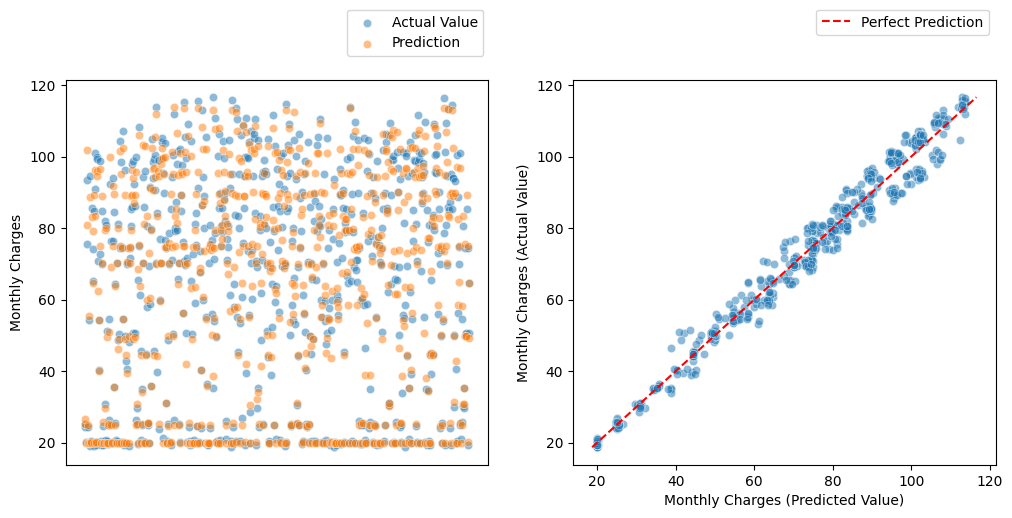

<Figure size 800x600 with 0 Axes>

In [37]:
plot_regression_model_performance(regression_model, test_data, test_targets)

In [38]:
# given this model I now want to find customers that pay "too" much and may as a result consider quitting their contract

In [39]:
def get_upper_and_lower_bound_for_outlier_detection(data: pd.DataFrame) -> tuple[float,float]:
    q3, q1 = np.percentile(data, [75, 25])
    IQR = q3 - q1

    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    return lower_bound, upper_bound

def get_data_indices_that_are_charged_to_much(residuals: list[float], upper_bound: float) -> list[int]:
    return [index for index in range(0, len(residuals)) if residuals[index] > upper_bound]

def get_data_for_customers_charged_too_much(all_data: pd.DataFrame, model: XGBRegressor, feature_data: pd.DataFrame, targets: list[float]) -> tuple[pd.DataFrame, list[float]]:
    regression_model_predictions = model.predict(feature_data)
    residuals = targets - regression_model_predictions
    
    lb, ub = get_upper_and_lower_bound_for_outlier_detection(residuals)
    
    indices_charged_to_much = get_data_indices_that_are_charged_to_much(residuals, upper_bound=ub)
    
    customer_charged_too_much = all_data.loc[feature_data.iloc[indices_charged_to_much].index]
    recommended_charges = regression_model_predictions[indices_charged_to_much].tolist()
    
    return customer_charged_too_much, recommended_charges

In [40]:
data_for_no_churn = data_with_enriched_features[data_with_enriched_features['Churn'] == 'No']

In [41]:
regression_model_feature_data, targets = generate_feature_df_and_targets_for_regression_model(data_for_no_churn)

In [42]:
customer_charged_too_much, recommended_charges = get_data_for_customers_charged_too_much(all_data=data_with_enriched_features, 
                                                                                         model=regression_model, 
                                                                                         feature_data=regression_model_feature_data, 
                                                                                         targets=targets)

In [43]:
print(f"Customers still present: {len(data_for_no_churn)}")
print(f"Amount of Customers charged too much: {len(customer_charged_too_much)}")
print(f"Revenue loss if they would leave: {customer_charged_too_much['MonthlyCharges'].sum()}")

Customers still present: 5174
Amount of Customers charged too much: 222
Revenue loss if they would leave: 18556.25


In [44]:
def create_pie_charts_for_charge_recommendation(customer_data_charged_too_much: pd.DataFrame, recommended_charges: list[float], all_data: pd.DataFrame):
    explode = (0, 0.15)
    colors = ['#8b0000','white']
    start_angle = 180
    bbox_anchor = (0.65, 0.9)
        
    total_amount_of_revenue = customer_data_charged_too_much['MonthlyCharges'].sum()
    lost_revenue = sum(customer_data_charged_too_much['MonthlyCharges'].to_numpy() - np.array(recommended_charges))
    print(lost_revenue)
    saved_revenue = total_amount_of_revenue - lost_revenue
    print(saved_revenue)
    
    plt.pie([lost_revenue, saved_revenue], explode=explode, colors=colors, startangle=start_angle)

    plt.axis('equal')
    
    plt.gca().patches[1].set_linewidth(1)
    plt.gca().patches[1].set_edgecolor('black')
    
    plt.legend(labels=['Lost Revenue', 'Saved Revenue'], loc="upper left",  bbox_to_anchor=bbox_anchor)
    
    print(f"Revenue Lost: {(lost_revenue / total_amount_of_revenue * 100):.2f} (rel), {lost_revenue:.2f} (abs)")
    print(f"Revenue Saved: {(saved_revenue / total_amount_of_revenue * 100):.2f} (rel), {saved_revenue:.2f} (abs)")
    plt.show()

1526.230556488037
17030.019443511963
Revenue Lost: 8.22 (rel), 1526.23 (abs)
Revenue Saved: 91.78 (rel), 17030.02 (abs)


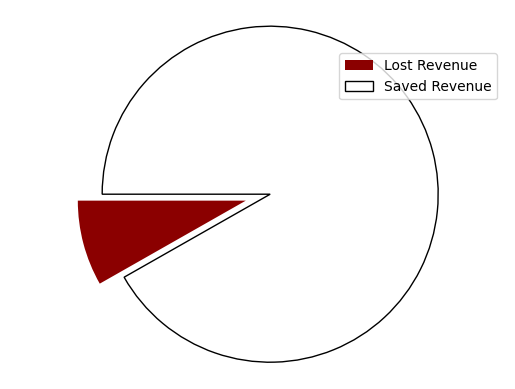

In [45]:
create_pie_charts_for_charge_recommendation(customer_data_charged_too_much=customer_charged_too_much, recommended_charges=recommended_charges, all_data=data)

# (Potential) Future Work
There is a myriad of things that could still be analysed and done. Here just a small collection

1. Combine the regression model above with the a better model for predicting churn to "simulate" if changes in the monthly charges would lead to a "flip" of the customer "churn"
    * The same could be done with the different assignments of services (TechSupport etc.). We could find a configuration that may lead to a change in the customers mind and as a result in a churn less
2. Experiment with other models. Try building an ensemble. XGB models are already powerful, non-linear ensemble models but could benefit from other approaches as well. What about a good, old linear regression? 
3. Reevalute the features/ feature engineering process. More granular features or even additional ones could lead to better results